<a href="https://colab.research.google.com/github/alhichri/COVID19-Detection-with-CNN-ensemble/blob/main/COVID19_detection_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_efficientnets
!pip install keras_applications

import keras_efficientnets 
from keras_efficientnets import efficientnet
from keras_efficientnets.custom_objects import Swish

     |████████████████████████████████| 51kB 1.6MB/s 


In [ ]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import glob
import itertools
import seaborn as sn
import time

from sklearn.metrics import confusion_matrix,   accuracy_score, precision_score, recall_score,f1_score, roc_auc_score  
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix

from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle
import matplotlib.image as mpimg
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

import tensorflow as tf
tf.__version__
from tensorflow.keras import utils as np_utils   #added
from tensorflow.keras.applications import inception_v3,inception_resnet_v2, densenet, vgg16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping , ModelCheckpoint
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive' , force_remount=True)

Mounted at /content/gdrive


In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

 
    
def plot_confusion_matrix2(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() +1).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def my_random_split(class_indeces , num_classes, trainSize):
            train_samples = np.zeros((2,1));         test_samples = np.zeros((2,1));
            for i in range(num_classes):
                class_size = np.sum(class_indeces[1,:] == i)
                idx = np.nonzero(class_indeces[1,:] == i)
                curr_class_idx   = class_indeces[0,idx]
                corresponding_labels = class_indeces[1,idx]
                indeces_permuted = np.vstack((  np.random.permutation(curr_class_idx[0])   , corresponding_labels[0]))
                samplesFraction = int(np.round(class_size * trainSize/100 ))
                train_indeces = indeces_permuted[:,0:samplesFraction]
                test_indeces = indeces_permuted[:,samplesFraction:]
                train_samples = np.hstack((train_samples, train_indeces))
                test_samples = np.hstack((test_samples, test_indeces))
            train_samples = train_samples.astype(int)
            test_samples = test_samples.astype(int)
            train_samples = train_samples[:,1:]
            test_samples = test_samples[:,1:]
    
            return train_samples, test_samples


def split_into_folds(class_indeces , num_classes, n_folds):
            fold_splits_indeces = [] ;  fold_splits_labels = [] 
            for f in range(n_folds):
                fold_splits_indeces.append([])
                fold_splits_labels.append([])
                
                
            for i in range(num_classes):
                class_size = np.sum(class_indeces[1,:] == i)
                idx = np.nonzero(class_indeces[1,:] == i)
                curr_class_idx   = class_indeces[0,idx]
                corresponding_labels = class_indeces[1,idx]
                indeces_permuted = np.vstack((  np.random.permutation(curr_class_idx[0])   , corresponding_labels[0]))
                samplesFraction = int(np.round(class_size / n_folds ))
                for f in range(n_folds-1):
                    fold_splits_indeces[f] = np.hstack( (  fold_splits_indeces[f]  ,   indeces_permuted[0,f*samplesFraction:(f+1)*samplesFraction]  )   )
                    fold_splits_labels[f] = np.hstack( (  fold_splits_labels[f]  ,   indeces_permuted[1,f*samplesFraction:(f+1)*samplesFraction]  )   )
                f=f+1; 
                fold_splits_indeces[f] = np.hstack( (  fold_splits_indeces[f]  ,   indeces_permuted[0,-samplesFraction:]  )   )
                fold_splits_labels[f] = np.hstack( (  fold_splits_labels[f]  ,   indeces_permuted[1,-samplesFraction:]  )   )
  
            for f in range(n_folds):
                fold_splits_indeces[f]  = fold_splits_indeces[f].astype(int)
                fold_splits_labels[f]   = fold_splits_labels[f].astype(int)  

            return fold_splits_indeces , fold_splits_labels

def save_training_results(path, trainSize, fold_number, model_name, TrainedModel,  y_prob3,y_prob4):
    fname = 'trainSize%i' %trainSize
    fname_with_path = path + model_name + '_' + 'best_'+  fname+'_fold'+str(fold_number)
    model_json = TrainedModel.to_json()
    with open(fname_with_path+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    TrainedModel.save_weights(fname_with_path+".h5")
    print("Saved model to disk: ", fname_with_path)

    fname = 'trainSize%i' %trainSize
    fname_with_path = path + model_name + '_'+ 'res_' +  fname+'_fold'+str(fold_number)
    D = {'y_prob3': y_prob3, 'y_prob4': y_prob4}
    np.savez(fname_with_path, **D)
    print("Saved results to disk: ", fname_with_path)






In [ ]:
###################################################################################################
########################## Parameters:  ##########################
dataset_path = '/content/gdrive/My Drive/COVID_19_CT_datasets/'
# dataset_path = '/content/gdrive/My Drive/ٌٌRP-Sahar alquzi/colab_codes/COVID_19_CT_datasets/'

dataset=2
trainSize = 20
fname_of_train_splits =  'train_splits_20_folds.npz' 
folds_list = np.asarray([0,1,2,3,4,5,6,7,8,9,10,11, 12,13,14,15,16,17,18,19])
training_folds =  folds_list[            :int(trainSize*20 /100)   ]
testing_folds = folds_list[            int(trainSize*20 /100):  ]
###################################################################################################
###################################################################################################
if dataset==1:
    dataset_folder = 'COVID_CT_by_Zhao/'; image_format = '.png'
    data_dir = dataset_path+dataset_folder+ '/images_folder' + '/'; print(data_dir)
    data_dir = pathlib.Path(data_dir)
    image_count = len(list(data_dir.glob('*/*'+image_format)))
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
    num_of_classes = len(CLASS_NAMES)
    print('num_of_classes: ' , num_of_classes)
    print('CLASS_NAMES: ' , CLASS_NAMES)
    print('total number of images in dataset: ' , image_count)
    class_size = np.zeros((num_of_classes)).astype('int')
    for cn in range(num_of_classes):
        path_name = dataset_path+ dataset_folder+ '/images_folder' + '/' + CLASS_NAMES[cn]
        data_dir = pathlib.Path(path_name)
        class_size[cn] = len(list(data_dir.glob('*'+image_format)))
        print('path name: ' , path_name , ' Class size: ' , class_size[cn])
    fname = dataset_path+'COVID-CT-soares.npz'
    D = np.load(fname)
    X = D['X']; y = D['y']
elif dataset==2:
    dataset_folder = 'SARS-CoV-2_CT-scan_Zhao/'; image_format = '.png'
    data_dir = dataset_path+dataset_folder+ 'images_folder/'; print(data_dir)
    data_dir = pathlib.Path(data_dir)
    image_count = len(list(data_dir.glob('*/*'+image_format)))
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
    num_of_classes = len(CLASS_NAMES)
    print('num_of_classes: ' , num_of_classes)
    print('CLASS_NAMES: ' , CLASS_NAMES)
    print('total number of images in dataset: ' , image_count)
    class_size = np.zeros((num_of_classes)).astype('int')
    for cn in range(num_of_classes):
        path_name = dataset_path+ dataset_folder+ '/images_folder' + '/' + CLASS_NAMES[cn]
        data_dir = pathlib.Path(path_name)
        class_size[cn] = len(list(data_dir.glob('*'+image_format)))
        print('path name: ' , path_name , ' Class size: ' , class_size[cn])  
    fname = dataset_path+dataset_folder+'SARS-CoV-2_CT-scan_.npz'
    D = np.load(fname)
    X = D['X']; y = D['y']

print('X.shape: ' , X.shape)
print('y.shape: ' , y.shape)

# Other datset information:
# 1229 1229
# 1252 1252
# image_num_rows_non_COVID min:  119.0 image_num_rows_non_COVID max:  416.0
# image_num_cols_non_COVID min:  224.0 image_num_cols_non_COVID max:  502.0
# image_num_rows_COVID min:  123.0 image_num_rows_COVID max:  408.0
# image_num_cols_COVID min:  182.0 image_num_cols_COVID max:  534.0
# X.shape:  (2481,)
# y.shape:  (2481,)



/content/gdrive/My Drive/COVID_19_CT_datasets/SARS-CoV-2_CT-scan_Zhao/images_folder/
num_of_classes:  2
CLASS_NAMES:  ['non-COVID' 'COVID']
total number of images in dataset:  2481
path name:  /content/gdrive/My Drive/COVID_19_CT_datasets/SARS-CoV-2_CT-scan_Zhao//images_folder/non-COVID  Class size:  1229
path name:  /content/gdrive/My Drive/COVID_19_CT_datasets/SARS-CoV-2_CT-scan_Zhao//images_folder/COVID  Class size:  1252
X.shape:  (2481, 256, 256, 3)
y.shape:  (2481,)


(2481, 256, 256, 3)
(2481,)
num_of_images_non_COVID:  1229
num_of_images_COVID:  1252


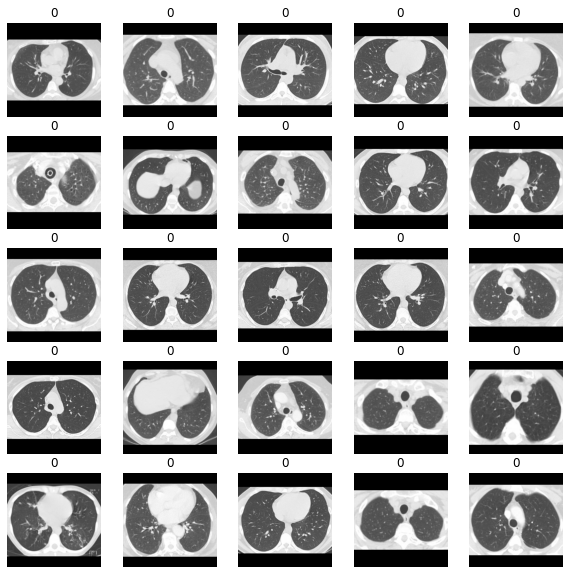

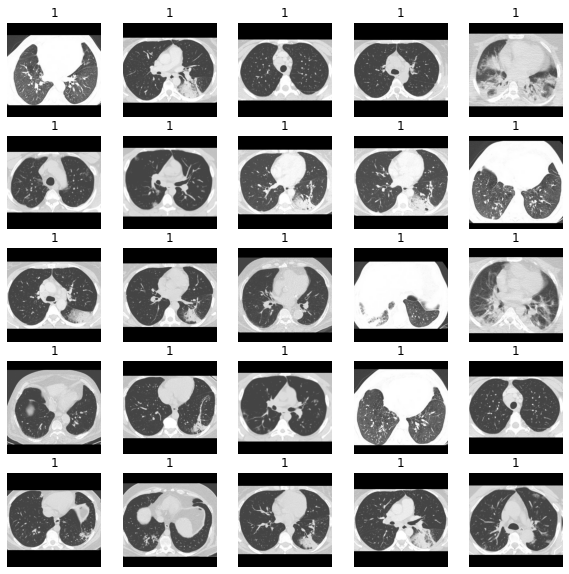

In [ ]:
print(X.shape)
print(y.shape)
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(   str(  label_batch[n]  )  )
      plt.axis('off')


# plot a hostogram of a band in an image
# plt.hist(lum_img.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')

num_of_images_non_COVID = np.sum(y==0)
num_of_images_COVID = np.sum(y==1)

print('num_of_images_non_COVID: ' , num_of_images_non_COVID)
print('num_of_images_COVID: ' , num_of_images_COVID)

show_batch(X[:25], y[:25])
show_batch(X[num_of_images_non_COVID:num_of_images_non_COVID+25], y[num_of_images_non_COVID:num_of_images_non_COVID+25])

In [ ]:
# ########################################################################
# #  Split data into 20 folds to prepare for training
# ########################################################################

# class_indeces = np.zeros((2,1));         
# for i in range(num_of_classes):
#     class_size = np.sum(y == i)
#     idx = np.nonzero(y == i) 
#     corresponding_labels = np.ones((class_size))*i
#     indeces =  np.vstack(( idx  , corresponding_labels  ))
#     class_indeces = np.hstack((class_indeces, indeces))
# class_indeces = class_indeces[:,1:]
# class_indeces = class_indeces.astype(int)


# fold_splits_indeces , fold_splits_labels = split_into_folds(class_indeces , num_of_classes, n_folds=20)
# fold_splits_indeces = np.asarray(fold_splits_indeces)
# fold_splits_labels = np.asarray(fold_splits_labels)

# print(fold_splits_indeces.shape)
# print(new_fold_splits_labels.shape)

# for i in range(fold_splits_indeces.shape[0]):
#     print(fold_splits_indeces[i,0:10])

# fname_with_path = dataset_path+dataset_folder + fname_of_train_splits
# D = {'fold_splits_indeces': fold_splits_indeces, 'fold_splits_labels': fold_splits_labels}
# np.savez(fname_with_path, **D)
# print("Saved results to disk: ", fname_with_path)



In [ ]:
# #  load data that is split into trainSet(20 folds) and testSet
path_of_train_splits = dataset_path+dataset_folder + fname_of_train_splits
print("Loading training splits to disk: ", path_of_train_splits)
D = np.load(path_of_train_splits)
fold_splits_indeces = D['fold_splits_indeces']; fold_splits_labels = D['fold_splits_labels']; 

print('Dataset Size: ' , X.shape)
print('Number of classes: ' , num_of_classes)
print('trainSize: ' , trainSize)

# find the number of classes in one fold
class_size = np.zeros((num_of_classes))
for i in range(num_of_classes):
    class_size[i] = np.sum(fold_splits_labels[0] == i)
print('class_size of one folds: ' , class_size)

def get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds):
  TT0 = []; TT1 = []
  for f in list_of_folds  :
      TT0 = np.hstack(( TT0 , fold_splits_indeces[f,:]   ))
      TT1 = np.hstack(( TT1 , fold_splits_labels[f,:]   ))
  train_samples = np.vstack(( TT0 , TT1   ))
  train_samples = train_samples.astype(int)
  return train_samples

print('Training folds : ' , training_folds); print('Testing folds : ' , testing_folds); 
train_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds)
test_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=testing_folds)

print('train_samples: ', train_samples.shape)
# print('val_samples: ', validation_samples.shape)
print('test_samples: ', test_samples.shape)

X_train =  X[train_samples[0]  ].copy()
y_train =  y[train_samples[0]  ].copy()
Y_train =  np_utils.to_categorical(y_train  ,   num_classes=num_of_classes)
X_test =  X[test_samples[0]  ].copy()
y_test =  y[test_samples[0]  ].copy()
Y_test =  np_utils.to_categorical(y_test  ,   num_classes=num_of_classes)


print("X_train  shape", X_train.shape)
print("Y_train  shape", Y_train.shape)
print("X_test  shape", X_test.shape)
print("y_test  shape", y_test.shape)



Loading training splits to disk:  /content/gdrive/My Drive/COVID_19_CT_datasets/SARS-CoV-2_CT-scan_Zhao/train_splits_20_folds.npz
Dataset Size:  (2481, 256, 256, 3)
Number of classes:  2
trainSize:  20
class_size of one folds:  [61. 63.]
Training folds :  [0 1 2 3]
Testing folds :  [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
train_samples:  (2, 496)
test_samples:  (2, 1984)
X_train  shape (496, 256, 256, 3)
Y_train  shape (496, 2)
X_test  shape (1984, 256, 256, 3)
y_test  shape (1984,)


In [ ]:
def build_efficientNet_CNN_V1(img_dim, num_classes):
    base_pretrained_model = efficientnet.EfficientNetB0(input_shape=img_dim, classes=1000,include_top=False, weights='imagenet')
    layer_index1 = -122  # 
    layer_index2 = -1   # 
    base_pretrained_model.trainable=True
    Total_Net_layers=len(base_pretrained_model.layers)
    #print(base_pretrained_model.output)
    xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out2')(base_pretrained_model.get_layer(index=layer_index2).output)
    output1 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)
    efficientModel =keras_efficientnets.efficientnet.Model(inputs=base_pretrained_model.input, outputs=output1)
    return efficientModel

def build_efficientNet_CNN_V2(img_dim, num_classes):
    base_pretrained_model = efficientnet.EfficientNetB3(input_shape=img_dim, classes=1000,include_top=False, weights='imagenet')
    layer_index1 = -122  # 
    layer_index2 = -1   # 
    base_pretrained_model.trainable=True
    Total_Net_layers=len(base_pretrained_model.layers)
    #print(base_pretrained_model.output)
    xx1= base_pretrained_model.get_layer(index=layer_index2).output
    xx1=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx1)
    bn_features1 =Swish()(xx1)
    xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out2')(bn_features1)
    output1 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)
    efficientModel =keras_efficientnets.efficientnet.Model(inputs=base_pretrained_model.input, outputs=output1)
    return efficientModel

In [ ]:
theCNNmodel = build_efficientNet_CNN_V1(img_dim=X[0].shape, num_classes=num_of_classes)
# theCNNmodel = build_efficientNet_CNN_V2(img_dim=X[0].shape, num_classes=num_of_classes)
theCNNmodel.summary()
from tensorflow.keras.utils import plot_model
plot_model(theCNNmodel, to_file='my_EfficientNet_model.png', show_shapes=True)
from IPython.display import Image
Image(filename='my_EfficientNet_model.png') 

43974656/43966704 [==============================] - 1s 0us/step
Training folds :  [0 1 2 3]
Testing folds :  [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
train_samples:  (2, 496)
test_samples:  (2, 1984)
X_train  shape (496, 256, 256, 3)
Y_train  shape (496, 2)
X_test  shape (1984, 256, 256, 3)
y_test  shape (1984,)
Epoch 1/20
16/16 [==============================] - 11s 669ms/step - loss: 0.3995 - accuracy: 0.8206
Epoch 2/20
16/16 [==============================] - 10s 644ms/step - loss: 0.1965 - accuracy: 0.9173
Epoch 3/20
16/16 [==============================] - 10s 649ms/step - loss: 0.0743 - accuracy: 0.9738
Epoch 4/20
16/16 [==============================] - 10s 650ms/step - loss: 0.0277 - accuracy: 0.9940
Epoch 5/20
16/16 [==============================] - 11s 658ms/step - loss: 0.0295 - accuracy: 0.9899
Epoch 6/20
16/16 [==============================] - 11s 663ms/step - loss: 0.0463 - accuracy: 0.9839
Epoch 7/20
16/16 [==============================] - 11s 669ms/step - l

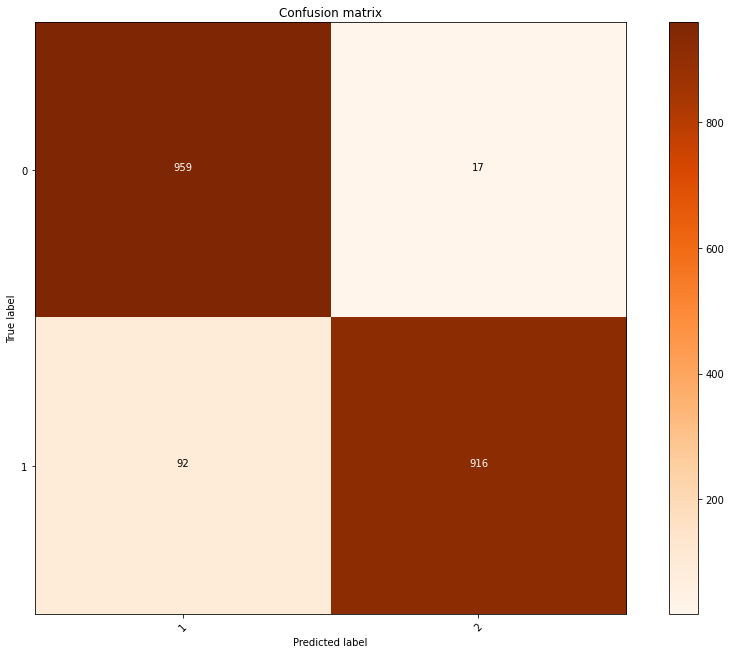

In [ ]:
# theCNNmodel = build_efficientNet_CNN_V1(img_dim=X[0].shape, num_classes=num_of_classes)
theCNNmodel = build_efficientNet_CNN_V2(img_dim=X[0].shape, num_classes=num_of_classes)
print('Training folds : ' , training_folds); print('Testing folds : ' , testing_folds); 
train_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds)
test_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=testing_folds)

print('train_samples: ', train_samples.shape)
# print('val_samples: ', validation_samples.shape)
print('test_samples: ', test_samples.shape)

X_train =  X[train_samples[0]  ].copy()
y_train =  y[train_samples[0]  ].copy()
Y_train =  np_utils.to_categorical(y_train  ,   num_classes=num_of_classes)
X_test =  X[test_samples[0]  ].copy()
y_test =  y[test_samples[0]  ].copy()
Y_test =  np_utils.to_categorical(y_test  ,   num_classes=num_of_classes)


print("X_train  shape", X_train.shape)
print("Y_train  shape", Y_train.shape)
print("X_test  shape", X_test.shape)
print("y_test  shape", y_test.shape)

X_train = efficientnet.preprocess_input(X_train.astype(np.float32))
X_test = efficientnet.preprocess_input(X_test.astype(np.float32))

learningRate = 0.001; batch_size = 32
theCNNmodel.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
history_1 = theCNNmodel.fit(X_train, Y_train, batch_size=batch_size, epochs=20, verbose=1, shuffle = True)
learningRate = learningRate*0.1
theCNNmodel.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
history_2 = theCNNmodel.fit(X_train, Y_train, batch_size=batch_size, epochs=15, verbose=1, shuffle = True)

y_prob_all = []; 
for k in range(2):
  history_2 = theCNNmodel.fit(X_train, Y_train, batch_size=batch_size, epochs=2, verbose=1, shuffle = True)
  y_prob = theCNNmodel.predict(X_test, batch_size = 32, verbose=1)  
  y_prob_all.append(y_prob)


y_prob_mean = np.zeros( (  y_prob_all[0].shape  )   )
OA = np.zeros(  ( len ( y_prob_all  ) )  )
for k in range(   len ( y_prob_all  )    ):
  Test_predicted = np.argmax(y_prob_all[k], axis=1)
  OA[k] = accuracy_score(y_test,Test_predicted)
  print('---->  Results with training size ', trainSize, ' percent' , OA[k] )
  y_prob_mean = y_prob_mean + y_prob_all[k]
y_prob1_mean = y_prob_mean / len ( y_prob_all  )

Test_predicted1 = np.argmax(y_prob1_mean, axis=1)
OA_fused = accuracy_score(y_test,Test_predicted1)
print('---->  Fused Results with training size ', trainSize, ' percent' , OA_fused )

print('---->  AVG Results with training size ', trainSize, ' percent. mean: ' , np.mean(OA) , 'STD: ' , np.std(OA) )


cnf_matrix =confusion_matrix(y_test,Test_predicted)
np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')
plt.figure(figsize = (12,9))
plot_confusion_matrix2(cnf_matrix)
#plot_confusion_matrix1(cnf_matrix, classes,  normalize=False, cmap=plt.cm.Blues)
plt.show()

# Test_predicted2 = np.argmax((y_prob[0]+y_prob[1]+y_prob[2]+y_prob[3]+y_prob[4])/5, axis=1)
# OA_final = accuracy_score(y_test,Test_predicted)
# print('---->  Final overall accuracy with training size ', trainSize, ' percent' , OA_final )


In [ ]:
print('---->  AVG Results with training size ', trainSize, ' percent. mean: ' , np.mean(OA) , 'STD: ' , np.std(OA) )


---->  AVG Results with training size  50  percent. mean:  0.9885752688172046 STD:  0.0021038273981852968


In [ ]:
base_pretrained_model = tf.keras.applications.MobileNetV2(input_shape=X[0].shape,
                                            include_top=False,
                                            weights='imagenet')  
base_pretrained_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
________________

In [ ]:

def build_efficientNet_CNN_V3(img_dim, num_classes):

    base_pretrained_model = efficientnet.EfficientNetB3(input_shape=img_dim, classes=1000,include_top=False, weights='imagenet')
    layer_index1 = -122  # 
    layer_index2 = -1   # 
    base_pretrained_model.trainable=True
    Total_Net_layers=len(base_pretrained_model.layers)
    #print(base_pretrained_model.output)
    xx1= base_pretrained_model.get_layer(index=layer_index2).output
    xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out2')(xx1)
    output1 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)
    efficientModel =keras_efficientnets.efficientnet.Model(inputs=base_pretrained_model.input, outputs=output1)
    return efficientModel
 

def build_efficientNet_CNN_V4(img_dim, num_classes):

    # base_pretrained_model = efficientnet.EfficientNetB3(input_shape=img_dim, classes=1000,include_top=False, weights='imagenet')
    base_pretrained_model = tf.keras.applications.MobileNetV2(input_shape=img_dim,
                                               include_top=False,
                                               weights='imagenet')
    base_pretrained_model.trainable=True
    Total_Net_layers = len(base_pretrained_model.layers)

    xx1 = keras_efficientnets.custom_objects.layers.Conv2D(1024, 3, strides=1)(base_pretrained_model.get_layer(index=-4).output)
    xx1=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx1)
    bn_features1 =Swish()(xx1)

    xx2  = keras_efficientnets.custom_objects.layers.Conv2D(1024, 3, strides=1)(base_pretrained_model.get_layer(index=-4).output)
    xx2=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx2)
    # = ZeroPadding2D(padding=(1, 1), data_format="channels_last")(F2)
    bn_features2 =Swish()(xx2)

    bn_features = keras_efficientnets.custom_objects.layers.Multiply(name='fea_map_out')([bn_features1, bn_features2 ] )
    print(bn_features.shape)

    # bn_features = keras_efficientnets.custom_objects.layers.AveragePooling2D(pool_size=(6,6),  name='fea_out')( bn_features )
    bn_features = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out')( bn_features )
    bn_features=keras_efficientnets.custom_objects.layers.BatchNormalization()(bn_features)
    # bn_features =Swish()(bn_features)
    # xx1 = keras_efficientnets.custom_objects.layers.Dropout(0.2)(xx1)

    # gap = keras_efficientnets.custom_objects.layers.Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP1')([gap_features, gap_mask])

    output1 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(bn_features)

    efficientModel =keras_efficientnets.efficientnet.Model(inputs=base_pretrained_model.input, outputs=output1)
    #efficientModel.summary()

    return efficientModel





In [ ]:

theCNNmodel = build_efficientNet_CNN_V3(img_dim=X[0].shape, num_classes=num_of_classes)
theCNNmodel.summary()


In [ ]:
# theCNNmodel = build_efficientNet_CNN_V3(img_dim=X[0].shape, num_classes=num_of_classes)
theCNNmodel = build_efficientNet_CNN_V4(img_dim=X[0].shape, num_classes=num_of_classes)


print('Training folds : ' , training_folds); print('Testing folds : ' , testing_folds); 
train_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds)
test_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=testing_folds)

print('train_samples: ', train_samples.shape)
# print('val_samples: ', validation_samples.shape)
print('test_samples: ', test_samples.shape)

X_train =  X[train_samples[0]  ].copy()
y_train =  y[train_samples[0]  ].copy()
Y_train =  np_utils.to_categorical(y_train  ,   num_classes=num_of_classes)
X_test =  X[test_samples[0]  ].copy()
y_test =  y[test_samples[0]  ].copy()
Y_test =  np_utils.to_categorical(y_test  ,   num_classes=num_of_classes)


print("X_train  shape", X_train.shape)
print("Y_train  shape", Y_train.shape)
print("X_test  shape", X_test.shape)
print("y_test  shape", y_test.shape)

X_train = efficientnet.preprocess_input(X_train.astype(np.float32))
X_test = efficientnet.preprocess_input(X_test.astype(np.float32))

learningRate = 0.001; batch_size = 32
theCNNmodel.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
history_1 = theCNNmodel.fit(X_train, Y_train, batch_size=batch_size, epochs=20, verbose=1, shuffle = True)
learningRate = learningRate*0.1
theCNNmodel.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
history_2 = theCNNmodel.fit(X_train, Y_train, batch_size=batch_size, epochs=15, verbose=1, shuffle = True)

y_prob_all = []; 
for k in range(2):
  history_2 = theCNNmodel.fit(X_train, Y_train, batch_size=batch_size, epochs=2, verbose=1, shuffle = True)
  y_prob = theCNNmodel.predict(X_test, batch_size = 32, verbose=1)  
  y_prob_all.append(y_prob)


y_prob_mean = np.zeros( (  y_prob_all[0].shape  )   )
OA = np.zeros(  ( len ( y_prob_all  ) )  )
for k in range(   len ( y_prob_all  )    ):
  Test_predicted = np.argmax(y_prob_all[k], axis=1)
  OA[k] = accuracy_score(y_test,Test_predicted)
  print('---->  Results with training size ', trainSize, ' percent' , OA[k] )
  y_prob_mean = y_prob_mean + y_prob_all[k]
y_prob1_mean = y_prob_mean / len ( y_prob_all  )

Test_predicted1 = np.argmax(y_prob1_mean, axis=1)
OA_fused = accuracy_score(y_test,Test_predicted1)
print('---->  Fused Results with training size ', trainSize, ' percent' , OA_fused )

print('---->  AVG Results with training size ', trainSize, ' percent. mean: ' , np.mean(OA) , 'STD: ' , np.std(OA) )


cnf_matrix =confusion_matrix(y_test,Test_predicted)
np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')
plt.figure(figsize = (12,9))
plot_confusion_matrix2(cnf_matrix)
#plot_confusion_matrix1(cnf_matrix, classes,  normalize=False, cmap=plt.cm.Blues)
plt.show()

# Test_predicted2 = np.argmax((y_prob[0]+y_prob[1]+y_prob[2]+y_prob[3]+y_prob[4])/5, axis=1)
# OA_final = accuracy_score(y_test,Test_predicted)
# print('---->  Final overall accuracy with training size ', trainSize, ' percent' , OA_final )

Training folds :  [0 1 2 3]
Testing folds :  [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
train_samples:  (2, 496)
test_samples:  (2, 1984)
X_train  shape (496, 256, 256, 3)
Y_train  shape (496, 2)
X_test  shape (1984, 256, 256, 3)
y_test  shape (1984,)
Epoch 1/20
16/16 [==============================] - 11s 691ms/step - loss: 2.1453 - dense_6_loss: 0.4054 - dense_7_loss: 0.4388 - dense_8_loss: 0.4332 - dense_9_loss: 0.4378 - dense_10_loss: 0.4300 - dense_6_accuracy: 0.8306 - dense_7_accuracy: 0.8105 - dense_8_accuracy: 0.8286 - dense_9_accuracy: 0.8206 - dense_10_accuracy: 0.8266
Epoch 2/20
16/16 [==============================] - 11s 663ms/step - loss: 0.6767 - dense_6_loss: 0.1375 - dense_7_loss: 0.1324 - dense_8_loss: 0.1359 - dense_9_loss: 0.1353 - dense_10_loss: 0.1357 - dense_6_accuracy: 0.9395 - dense_7_accuracy: 0.9556 - dense_8_accuracy: 0.9516 - dense_9_accuracy: 0.9496 - dense_10_accuracy: 0.9476
Epoch 3/20
16/16 [==============================] - 11s 665ms/step - loss

AttributeError: ignored

In [ ]:
print(len(y_prob_all[0]))
print( y_prob_all[0][0].shape )

y_prob_all_new = []
for i in range(2):
  for j in range(5):
    y_prob_all_new.append(y_prob_all[i][j])

y_prob_all_new = np.asarray(y_prob_all_new)
print(y_prob_all_new.shape )

y_prob_all = []


y_prob_all = y_prob_all_new
print(y_prob_all.shape )


IndexError: ignored

(10, 1984, 2)
---->  Results with training size  20  percent 0.9400201612903226
---->  Results with training size  20  percent 0.9430443548387096
---->  Results with training size  20  percent 0.9420362903225806
---->  Results with training size  20  percent 0.9415322580645161
---->  Results with training size  20  percent 0.9425403225806451
---->  Results with training size  20  percent 0.9168346774193549
---->  Results with training size  20  percent 0.9017137096774194
---->  Results with training size  20  percent 0.9012096774193549
---->  Results with training size  20  percent 0.9022177419354839
---->  Results with training size  20  percent 0.9012096774193549
---->  Fused Results with training size  20  percent 0.9319556451612904
---->  AVG Results with training size  20  percent. mean:  0.9232358870967741 STD:  0.019108141441839435
Confusion matrix, without normalization


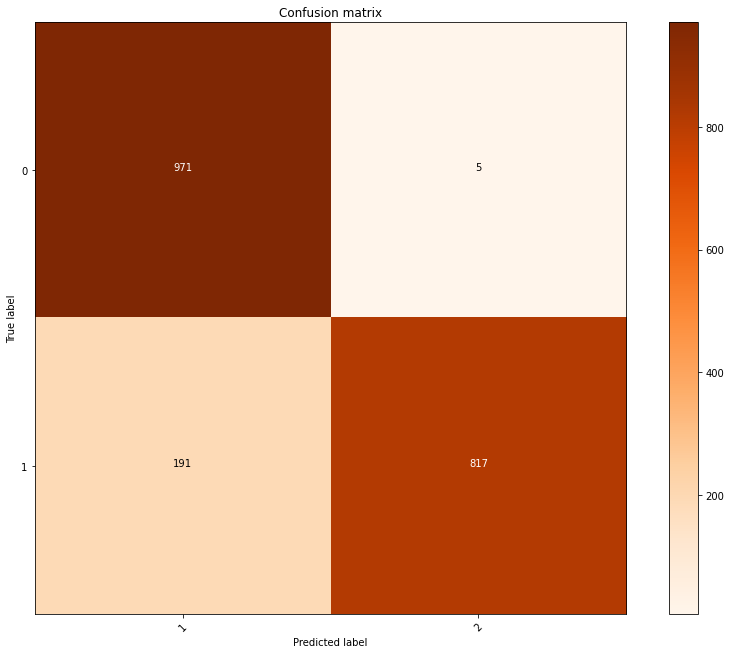

In [ ]:

print(y_prob_all_new.shape )
y_prob_all = y_prob_all_new
y_prob_mean = np.zeros( (  y_prob_all[0].shape  )   )
OA = np.zeros(  ( len ( y_prob_all  ) )  )
for k in range(   len ( y_prob_all  )    ):
  Test_predicted = np.argmax(y_prob_all[k], axis=1)
  OA[k] = accuracy_score(y_test,Test_predicted)
  print('---->  Results with training size ', trainSize, ' percent' , OA[k] )
  y_prob_mean = y_prob_mean + y_prob_all[k]
y_prob1_mean = y_prob_mean / len ( y_prob_all  )

Test_predicted1 = np.argmax(y_prob1_mean, axis=1)
OA_fused = accuracy_score(y_test,Test_predicted1)
print('---->  Fused Results with training size ', trainSize, ' percent' , OA_fused )

print('---->  AVG Results with training size ', trainSize, ' percent. mean: ' , np.mean(OA) , 'STD: ' , np.std(OA) )


cnf_matrix =confusion_matrix(y_test,Test_predicted)
np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')
plt.figure(figsize = (12,9))
plot_confusion_matrix2(cnf_matrix)
#plot_confusion_matrix1(cnf_matrix, classes,  normalize=False, cmap=plt.cm.Blues)
plt.show()


In [ ]:
def build_efficientNet_CNN_V5(img_dim, num_classes):
  base_pretrained_model = efficientnet.EfficientNetB3(input_shape=img_dim, classes=1000,include_top=False, weights='imagenet')
  base_pretrained_model.trainable=True
  Total_Net_layers=len(base_pretrained_model.layers)

  xx1 = base_pretrained_model.get_layer(index=-122+3).output
  xx1  = keras_efficientnets.custom_objects.layers.Conv2D(128, 3, strides=1)(xx1)
  xx1=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx1)
  bn_features1 =Swish()(xx1)
  xx1 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out1')(xx1)
  xx1 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx1)
  output1 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx1)

  #print(base_pretrained_model.output)
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out2')(base_pretrained_model.get_layer(index=-1).output)
  # xx2 = keras_efficientnets.custom_objects.layers.Dense(128, activation='Swish')(xx2)
  output2 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)


  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out3')(base_pretrained_model.get_layer(index=-1).output)
  output3 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)

  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out4')(base_pretrained_model.get_layer(index=-1).output)
  output4 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)

  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out5')(base_pretrained_model.get_layer(index=-1).output)
  output5 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)


  ######### Model with auxiliary classification loss........
  efficientModel =keras_efficientnets.efficientnet.Model(inputs=base_pretrained_model.input, outputs=[output1,output2,output3,output4,output5])
  #efficientModel.summary()

  return efficientModel


def build_efficientNet_CNN_V6(img_dim, num_classes):
  base_pretrained_model = efficientnet.EfficientNetB3(input_shape=img_dim, classes=1000,include_top=False, weights='imagenet')
  base_pretrained_model.trainable=True
  Total_Net_layers=len(base_pretrained_model.layers)

  xx1 =  base_pretrained_model.get_layer(index=-33+3).output
  xx1 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out1')(xx1)
  # xx1 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx1)
  output1 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx1)

  #print(base_pretrained_model.output)
  xx2 =  base_pretrained_model.get_layer(index=-1).output
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out2')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dense(128, activation='Swish')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx2)
  output2 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)

  xx2 =  base_pretrained_model.get_layer(index=-1).output
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out3')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx2)
  output3 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)

  xx2 =  base_pretrained_model.get_layer(index=-1).output
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out4')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx2)
  output4 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)

  xx2 =  base_pretrained_model.get_layer(index=-1).output
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out5')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx2)
  output5 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)


  ######### Model with auxiliary classification loss........
  efficientModel =keras_efficientnets.efficientnet.Model(inputs=base_pretrained_model.input, outputs=[output1,output2,output3,output4,output5])
  #efficientModel.summary()

  return efficientModel


def build_efficientNet_CNN_V7(img_dim, num_classes):
  base_pretrained_model = efficientnet.EfficientNetB3(input_shape=img_dim, classes=1000,include_top=False, weights='imagenet')
  base_pretrained_model.trainable=True
  Total_Net_layers=len(base_pretrained_model.layers)

  xx1 =  base_pretrained_model.get_layer(index=-33+3).output
  xx1 = keras_efficientnets.custom_objects.layers.BatchNormalization()(xx1)
  xx1 = Swish()(xx1)
  xx1 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out1')(xx1)
  # xx1 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx1)
  output1 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx1)

  #print(base_pretrained_model.output)
  xx2 =  base_pretrained_model.get_layer(index=-1).output
  xx2=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx2)
  xx2 = Swish()(xx2)
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out2')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dense(128, activation='Swish')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx2)
  output2 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)

  xx2 =  base_pretrained_model.get_layer(index=-1).output
  xx2=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx2)
  xx2 = Swish()(xx2)
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out3')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx2)
  output3 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)

  xx2 =  base_pretrained_model.get_layer(index=-1).output
  xx2=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx2)
  xx2 = Swish()(xx2)
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out4')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx2)
  output4 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)

  xx2 =  base_pretrained_model.get_layer(index=-1).output
  xx2=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx2)
  xx2 = Swish()(xx2)
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out5')(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx2)
  output5 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)


  ######### Model with auxiliary classification loss........
  efficientModel =keras_efficientnets.efficientnet.Model(inputs=base_pretrained_model.input, outputs=[output1,output2,output3,output4,output5])
  #efficientModel.summary()

  return efficientModel



In [ ]:
theCNNmodel = build_efficientNet_CNN_V7(img_dim=X[0].shape, num_classes=num_of_classes)
theCNNmodel.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_729 (Conv2D)             (None, 128, 128, 40) 1080        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_550 (BatchN (None, 128, 128, 40) 160         conv2d_729[0][0]                 
__________________________________________________________________________________________________
swish_550 (Swish)               (None, 128, 128, 40) 0           batch_normalization_550[0][0]    
______________________________________________________________________________________

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(theCNNmodel, to_file='my_EfficientNet_model.png', show_shapes=True)
from IPython.display import Image
Image(filename='my_EfficientNet_model.png') 

Training folds :  [0 1 2 3]
Testing folds :  [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
train_samples:  (2, 496)
test_samples:  (2, 1984)
X_train  shape (496, 256, 256, 3)
Y_train  shape (496, 2)
X_test  shape (1984, 256, 256, 3)
y_test  shape (1984,)
Epoch 1/20
16/16 [==============================] - 7s 467ms/step - loss: 2.0677 - dense_27_loss: 0.5864 - dense_28_loss: 0.3675 - dense_29_loss: 0.3776 - dense_30_loss: 0.3608 - dense_31_loss: 0.3754 - dense_27_accuracy: 0.6794 - dense_28_accuracy: 0.8286 - dense_29_accuracy: 0.8165 - dense_30_accuracy: 0.8488 - dense_31_accuracy: 0.8185
Epoch 2/20
16/16 [==============================] - 7s 456ms/step - loss: 0.8535 - dense_27_loss: 0.2671 - dense_28_loss: 0.1499 - dense_29_loss: 0.1402 - dense_30_loss: 0.1473 - dense_31_loss: 0.1490 - dense_27_accuracy: 0.9395 - dense_28_accuracy: 0.9456 - dense_29_accuracy: 0.9536 - dense_30_accuracy: 0.9415 - dense_31_accuracy: 0.9456
Epoch 3/20
16/16 [==============================] - 7s 457m

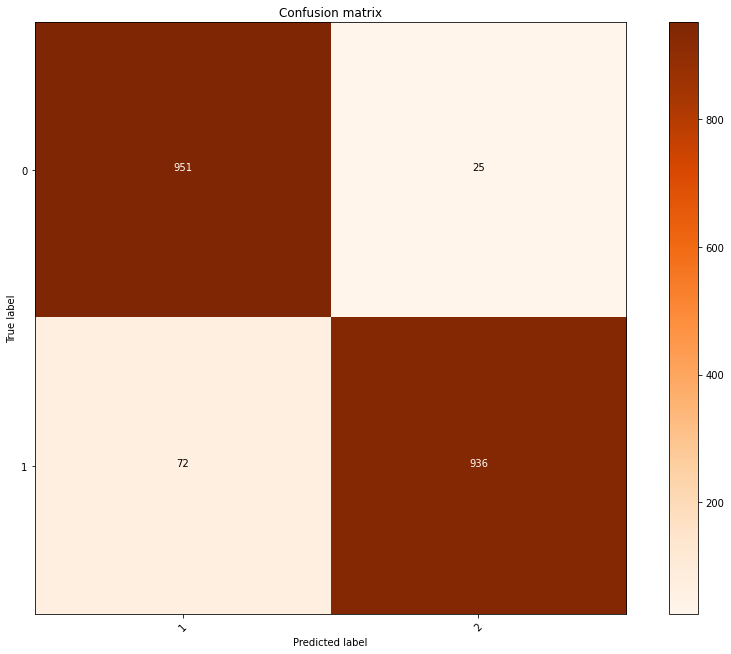

In [ ]:
theCNNmodel = build_efficientNet_CNN_V6(img_dim=X[0].shape, num_classes=num_of_classes)

print('Training folds : ' , training_folds); print('Testing folds : ' , testing_folds); 
train_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds)
test_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=testing_folds)

print('train_samples: ', train_samples.shape)
# print('val_samples: ', validation_samples.shape)
print('test_samples: ', test_samples.shape)

X_train =  X[train_samples[0]  ].copy()
y_train =  y[train_samples[0]  ].copy()
Y_train =  np_utils.to_categorical(y_train  ,   num_classes=num_of_classes)
X_test =  X[test_samples[0]  ].copy()
y_test =  y[test_samples[0]  ].copy()
Y_test =  np_utils.to_categorical(y_test  ,   num_classes=num_of_classes)


print("X_train  shape", X_train.shape)
print("Y_train  shape", Y_train.shape)
print("X_test  shape", X_test.shape)
print("y_test  shape", y_test.shape)

X_train = efficientnet.preprocess_input(X_train.astype(np.float32))
X_test = efficientnet.preprocess_input(X_test.astype(np.float32))

learningRate = 0.001; batch_size = 32
theCNNmodel.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
history_1 = theCNNmodel.fit(X_train, [Y_train,Y_train,Y_train,Y_train,Y_train], batch_size=batch_size, epochs=20, verbose=1, shuffle = True)
learningRate = learningRate*0.1
theCNNmodel.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
history = theCNNmodel.fit(X_train, [Y_train,Y_train,Y_train,Y_train,Y_train], batch_size=batch_size, epochs=15, verbose=1, shuffle = True)

y_prob_all = []
y_prob = theCNNmodel.predict(X_test, batch_size = 32, verbose=1) 
for j in range(5):
  y_prob_all.append(y_prob[j])

history = theCNNmodel.fit(X_train, [Y_train,Y_train,Y_train,Y_train,Y_train], batch_size=batch_size, epochs=3, verbose=1, shuffle = True)
y_prob = theCNNmodel.predict(X_test, batch_size = 32, verbose=1) 
for j in range(5):
  y_prob_all.append(y_prob[j])

history = theCNNmodel.fit(X_train, [Y_train,Y_train,Y_train,Y_train,Y_train], batch_size=batch_size, epochs=3, verbose=1, shuffle = True)
y_prob = theCNNmodel.predict(X_test, batch_size = 32, verbose=1) 
for j in range(5):
  y_prob_all.append(y_prob[j])

y_prob_mean = np.zeros( (  y_prob_all[0].shape  )   )
OA = np.zeros(  ( len ( y_prob_all  ) )  )
for k in range(   len (y_prob_all)    ):
  Test_predicted = np.argmax(y_prob_all[k], axis=1)
  OA[k] = accuracy_score(y_test,Test_predicted)
  print('---->  Results with training size ', trainSize, ' percent' , OA[k] )
  y_prob_mean = y_prob_mean + y_prob_all[k]
y_prob2_mean = y_prob_mean / len ( y_prob_all  )

Test_predicted2 = np.argmax(y_prob2_mean, axis=1)
OA_fused = accuracy_score(y_test,Test_predicted2)
print('---->  Fused Results with training size ', trainSize, ' percent' , OA_fused )

print('---->  AVG Results with training size ', trainSize, ' percent. mean: ' , np.mean(OA) , 'STD: ' , np.std(OA) )

cnf_matrix =confusion_matrix(y_test,Test_predicted2)
np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')
plt.figure(figsize = (12,9))
plot_confusion_matrix2(cnf_matrix)
#plot_confusion_matrix1(cnf_matrix, classes,  normalize=False, cmap=plt.cm.Blues)
plt.show()

# Test_predicted2 = np.argmax((y_prob[0]+y_prob[1]+y_prob[2]+y_prob[3]+y_prob[4])/5, axis=1)
# OA_final = accuracy_score(y_test,Test_predicted)
# print('---->  Final overall accuracy with training size ', trainSize, ' percent' , OA_final )

# for j in range(5):
#   y_prob_both.append(y_prob[j])


In [ ]:

model_name = 'efficientnetB3'
save_training_results(path=res_path, trainSize=int(100*trainSize), fold_number=99,model_name=model_name, TrainedModel=theCNNmodel, y_prob3=y_prob3,y_prob4=y_prob4)



In [ ]:
def build_efficientNet_CNN_V8(img_dim, num_classes):
  base_pretrained_model = efficientnet.EfficientNetB3(input_shape=img_dim, classes=1000,include_top=False, weights='imagenet')
  base_pretrained_model.trainable=True
  Total_Net_layers=len(base_pretrained_model.layers)

  xx1 =  base_pretrained_model.get_layer(index=-1).output
  # xx1  = keras_efficientnets.custom_objects.layers.Conv2D(816, 3, strides=(1,1) )(xx1)
  # xx1 = keras_efficientnets.custom_objects.layers.BatchNormalization()(xx1)
  # xx1 = Swish()(xx1)
  xx1 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out1')(xx1)
  # xx1 = keras_efficientnets.custom_objects.layers.Dropout(0.2)(xx1)
  output1 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx1)

  #print(base_pretrained_model.output)
  xx2 =  base_pretrained_model.get_layer(index=-1).output
  xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out2')(xx2)
  xx2 = keras_efficientnets.custom_objects.layers.Dense(128)(xx2)
  # xx2  = keras_efficientnets.custom_objects.layers.Conv2D(1536, 1, strides=(1,1) )(xx2)
  xx2=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx2)
  xx2 = Swish()(xx2)
  # xx2 = keras_efficientnets.custom_objects.layers.Dropout(0.2)(xx2)
  output2 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)

    ######### Model with auxiliary classification loss........
  efficientModel =keras_efficientnets.efficientnet.Model(inputs=base_pretrained_model.input, outputs=[output1,output2])
  #efficientModel.summary()

  return efficientModel

In [ ]:
theCNNmodel = build_efficientNet_CNN_V8(img_dim=X[0].shape, num_classes=num_of_classes)

theCNNmodel.summary()

ValueError: ignored

In [ ]:
theCNNmodel = build_efficientNet_CNN_V8(img_dim=X[0].shape, num_classes=num_of_classes)
from tensorflow.keras.utils import plot_model
plot_model(theCNNmodel, to_file='my_EfficientNet_model.png', show_shapes=True)
from IPython.display import Image
Image(filename='my_EfficientNet_model.png') 

Training folds :  [0 1 2 3]
Testing folds :  [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
train_samples:  (2, 496)
test_samples:  (2, 1984)
X_train  shape (496, 256, 256, 3)
Y_train  shape (496, 2)
X_test  shape (1984, 256, 256, 3)
y_test  shape (1984,)
Epoch 1/20
16/16 [==============================] - 7s 468ms/step - loss: 0.8525 - dense_13_loss: 0.3952 - dense_15_loss: 0.4572 - dense_13_accuracy: 0.8367 - dense_15_accuracy: 0.8065
Epoch 2/20
16/16 [==============================] - 8s 470ms/step - loss: 0.3785 - dense_13_loss: 0.1800 - dense_15_loss: 0.1984 - dense_13_accuracy: 0.9476 - dense_15_accuracy: 0.9435
Epoch 3/20
16/16 [==============================] - 7s 458ms/step - loss: 0.1537 - dense_13_loss: 0.0779 - dense_15_loss: 0.0758 - dense_13_accuracy: 0.9758 - dense_15_accuracy: 0.9718
Epoch 4/20
16/16 [==============================] - 7s 459ms/step - loss: 0.1776 - dense_13_loss: 0.0904 - dense_15_loss: 0.0872 - dense_13_accuracy: 0.9798 - dense_15_accuracy: 0.9819
E

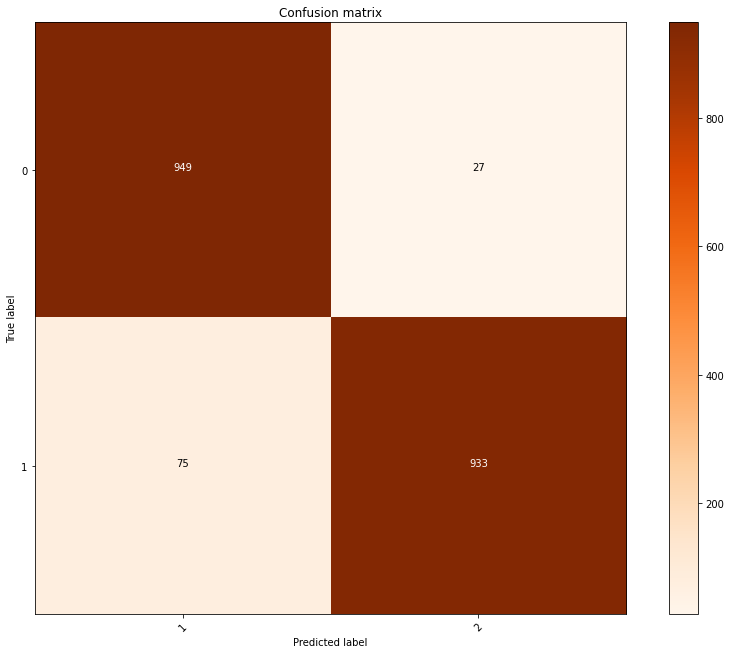

In [ ]:
theCNNmodel = build_efficientNet_CNN_V8(img_dim=X[0].shape, num_classes=num_of_classes)

print('Training folds : ' , training_folds); print('Testing folds : ' , testing_folds); 
train_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds)
test_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=testing_folds)

print('train_samples: ', train_samples.shape)
# print('val_samples: ', validation_samples.shape)
print('test_samples: ', test_samples.shape)

X_train =  X[train_samples[0]  ].copy()
y_train =  y[train_samples[0]  ].copy()
Y_train =  np_utils.to_categorical(y_train  ,   num_classes=num_of_classes)
X_test =  X[test_samples[0]  ].copy()
y_test =  y[test_samples[0]  ].copy()
Y_test =  np_utils.to_categorical(y_test  ,   num_classes=num_of_classes)


print("X_train  shape", X_train.shape)
print("Y_train  shape", Y_train.shape)
print("X_test  shape", X_test.shape)
print("y_test  shape", y_test.shape)

X_train = efficientnet.preprocess_input(X_train.astype(np.float32))
X_test = efficientnet.preprocess_input(X_test.astype(np.float32))

learningRate = 0.001; batch_size = 32
theCNNmodel.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
history_1 = theCNNmodel.fit(X_train, [Y_train,Y_train], batch_size=batch_size, epochs=20, verbose=1, shuffle = True)
learningRate = learningRate*0.1
theCNNmodel.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
history = theCNNmodel.fit(X_train, [Y_train,Y_train], batch_size=batch_size, epochs=15, verbose=1, shuffle = True)

y_prob_all = []
y_prob = theCNNmodel.predict(X_test, batch_size = 32, verbose=1) 
for j in range(2):
  y_prob_all.append(y_prob[j])

history = theCNNmodel.fit(X_train, [Y_train,Y_train], batch_size=batch_size, epochs=5, verbose=1, shuffle = True)
y_prob = theCNNmodel.predict(X_test, batch_size = 32, verbose=1) 
for j in range(2):
  y_prob_all.append(y_prob[j])

y_prob_mean = np.zeros( (  y_prob_all[0].shape  )   )
OA = np.zeros(  ( len ( y_prob_all  ) )  )
for k in range(   len (y_prob_all)    ):
  Test_predicted = np.argmax(y_prob_all[k], axis=1)
  OA[k] = accuracy_score(y_test,Test_predicted)
  print('---->  Results with training size ', trainSize, ' percent' , OA[k] )
  y_prob_mean = y_prob_mean + y_prob_all[k]
y_prob2_mean = y_prob_mean / len ( y_prob_all  )

Test_predicted2 = np.argmax(y_prob2_mean, axis=1)
OA_fused = accuracy_score(y_test,Test_predicted2)
print('---->  Fused Results with training size ', trainSize, ' percent' , OA_fused )

print('---->  AVG Results with training size ', trainSize, ' percent. mean: ' , np.mean(OA) , 'STD: ' , np.std(OA) )

cnf_matrix =confusion_matrix(y_test,Test_predicted2)
np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')
plt.figure(figsize = (12,9))
plot_confusion_matrix2(cnf_matrix)
#plot_confusion_matrix1(cnf_matrix, classes,  normalize=False, cmap=plt.cm.Blues)
plt.show()

# Test_predicted2 = np.argmax((y_prob[0]+y_prob[1]+y_prob[2]+y_prob[3]+y_prob[4])/5, axis=1)
# OA_final = accuracy_score(y_test,Test_predicted)
# print('---->  Final overall accuracy with training size ', trainSize, ' percent' , OA_final )

# for j in range(5):
#   y_prob_both.append(y_prob[j])


In [ ]:
theCNNmodel.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 128, 128, 40) 1080        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_79 (BatchNo (None, 128, 128, 40) 160         conv2d_104[0][0]                 
__________________________________________________________________________________________________
swish_79 (Swish)                (None, 128, 128, 40) 0           batch_normalization_79[0][0]     
_______________________________________________________________________________________